In [3]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns
from emcee.backends import HDFBackend
from read_files import *
from run_mcmc import HODParameter

In [4]:
with open('./configs/config_delta_z2.yaml', 'r') as f:
    par_configs, other_configs = list(yaml.load_all(f, yaml.FullLoader))
    # ========== reading configs ==========
    # don't set the lgMmin too large or sig_lgM too small, otherwise N_c will be all zeros
    available_fields = ['Nwalkers', 'Nstep', 'Nburnin', 'Npro', 'auto_range', 'cross_range',
                        'backend_file', 'numpy_file', 'wp_table_path', 'signal_path', 'module_path']
    Nwalkers = 40
    Nstep = 4000
    Nburnin = 300
    Npro = 40
    auto_range = None
    cross_range = None
    backend_file = ''
    numpy_file = ''
    wp_table_path = '../wp_table'
    signal_path = '../signal'
    module_path = './HOD/calc_wp.py'

    for k in available_fields:
        if k in other_configs:
            locals()[k] = other_configs[k]

    wp_table = read_wp(wp_table_path)
    rp_auto, signal_auto, rp_cross, signal_cross = read_signal(signal_path + '/signal.npy')
    cov = read_cov(signal_path + '/cov.npy')
    logM, Nh = read_halo_mass_function('../halo_mass_function.npy')
    module = read_module(module_path)
    chi_2 = module.chi_2
    N_c = module.N_c
    # for better performance I would recommend setting these as global variable
    # ========== apply the fitting range ==========

    if auto_range or cross_range:
        if auto_range is None:
            auto_range = [0, len(rp_auto)]
        if cross_range is None:
            cross_range = [0, len(rp_cross)]
        l_a, r_a = auto_range[0], auto_range[1]
        l_c, r_c = cross_range[0], cross_range[1]

        auto_size = len(rp_auto)
        cross_size = len(rp_cross)
        rp_auto = rp_auto[l_a:r_a]
        rp_cross = rp_cross[l_c:r_c]
        signal_auto = signal_auto[l_a:r_a]
        signal_cross = signal_cross[l_c:r_c]

        cov = np.vstack((
            np.hstack((cov[l_c:r_c, l_c:r_c], cov[l_c:r_c, cross_size+l_a:cross_size+r_a])),
            np.hstack((cov[cross_size+l_a:cross_size+r_a, l_c:r_c], cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a]))
        ))

    signal = np.hstack((signal_cross, signal_auto))
    cov_inv = np.linalg.inv(cov)

    # ========== handle interpolating table ==========
    wp_table_auto = interpolate_table(wp_table, rp_auto)
    wp_table_cross = interpolate_table(wp_table, rp_cross)

    parameter = HODParameter.from_config(par_configs)
    dof = len(signal) - parameter.ndim
    print(parameter)
    print('dof = {}'.format(dof))

HODParameter(lgM0:      14  [10~17])
dof = 29


In [5]:
if not numpy_file.endswith('.npy'):
    numpy_file += '.npy'
result = np.load(numpy_file)
array_res = result.view((np.float64, len(result.dtype.names)))

/tmp/ipykernel_3198408/1251819693.py:4: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  array_res = result.view((np.float64, len(result.dtype.names)))


In [6]:
par = parameter.full_parameters(np.percentile(array_res, 50, axis=0))

[]

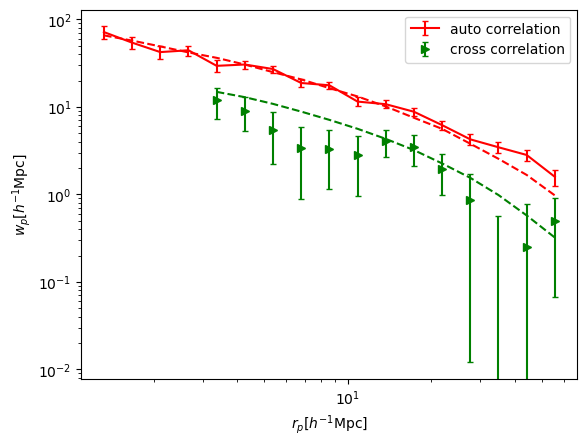

In [7]:
par = parameter.full_parameters(np.percentile(array_res, 50, axis=0))
predict = module.w_p(logM, Nh, par, wp_table_auto, wp_table_cross)
pre_cross = predict[:len(rp_cross)]
pre_auto = predict[len(rp_cross):]
std = np.sqrt([cov[i, i] for i in range(len(signal))])
err_cross = std[:len(rp_cross)]
err_auto = std[len(rp_cross):]
plt.errorbar(rp_auto, signal_auto, err_auto, fmt='r', capsize=2, label='auto correlation')
plt.errorbar(rp_cross, signal_cross, err_cross, fmt='g>', capsize=2, label='cross correlation')
plt.plot(rp_auto, pre_auto, 'r--')
plt.plot(rp_cross, pre_cross, 'g--')
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
plt.legend()
plt.loglog()

In [36]:
rp_auto

array([ 1.32367962,  1.67227667,  2.11267834,  2.6690618 ,  3.37197138,
        4.25999539,  5.38188457,  6.79922837,  8.58983612, 10.85200857,
       13.70993443, 17.32050808, 21.88194273, 27.64465197, 34.92499691,
       44.12265385, 55.74255561])

In [37]:
signal_auto

array([71.62391972, 54.21306081, 42.29058074, 44.36269195, 29.45809225,
       30.50017131, 27.07832603, 18.7574218 , 17.65729094, 11.50011068,
       10.73762269,  8.80524465,  6.18725592,  4.25864754,  3.4570399 ,
        2.82373817,  1.58897985])

In [38]:
err_auto

array([11.46386881,  8.59159158,  7.14385156,  5.77191138,  4.5281732 ,
        3.31946847,  2.63837897,  2.03258965,  1.81285635,  1.3873286 ,
        1.10178554,  0.92308165,  0.71935318,  0.61590443,  0.5085055 ,
        0.39725866,  0.33097878])

<Axes: ylabel='Count'>

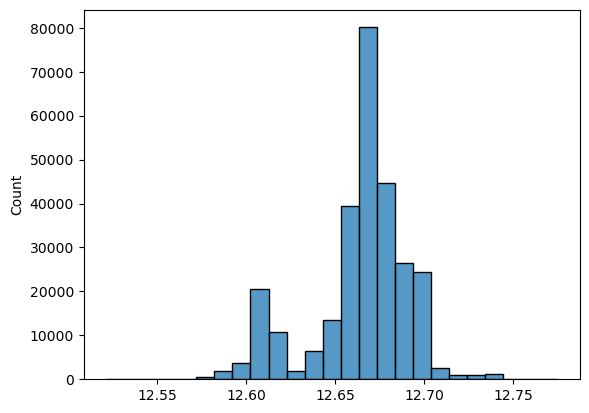

In [29]:
sns.histplot(array_res, binwidth=0.01)

In [30]:
res = np.percentile(array_res, [50-34.1, 50, 50+34.1])
print(res[1], res[1]-res[0], res[2]-res[1])

12.668327414973291 0.02668962303780198 0.01990532617567453
